**Problem Set #2**

Computational Electromagnetism and Applications (ΥΦΥ203)

Implemented by: **Anastasios-Faidon Retselis (AEM: 4394)**

# Exercise 2.1

Plot the fraction of the numerical to the analytical phase velocity (see slide 4-23 of S. Gedney) as a function of the angle of incidence $\theta$ for (a) $\Delta x = \Delta y = \lambda/10$ and (b) $ \Delta x = \lambda/10,\; \Delta y = \lambda/20$. For both cases, choose the time step to be equal to 90% of the stability limit.

## Solution

The stability limit for the two-dimensional explicit equation is given by the following formula:

$$
\Delta t<\frac{1}{c \sqrt{\frac{1}{\Delta x^{2}}+\frac{1}{\Delta y^{2}}}}
$$

which can be further simplified if $\Delta x =\Delta y=\Delta$:

$$
\Delta t<\frac{\Delta}{c \sqrt{2}}
$$

and from these two equations we can calculate the desired time stop to be some percentage of the stability limit. 

From the dispersion relationship in discrete space:

$$
\frac{1}{c^{2} \Delta t^{2}} \sin ^{2}\left(\frac{\omega \Delta t}{2}\right)-\frac{1}{\Delta x^{2}} \sin ^{2}\left(\frac{\tilde{k}_{x} \Delta x}{2}\right)-\frac{1}{\Delta y^{2}} \sin ^{2}\left(\frac{\tilde{k}_{y} \Delta y}{2}\right)=0
$$

we can substitute $\tilde{k}_{x}=\tilde{k}cos(\theta)$ and $\tilde{k}_{y}=\tilde{k}sin(\theta)$, leading to:

$$
\frac{1}{c^{2} \Delta t^{2}} \sin ^{2}\left(\frac{\omega \Delta t}{2}\right)=\frac{1}{\Delta x^{2}} \sin ^{2}\left(\frac{\tilde{k} \cos (\theta) \Delta x}{2}\right)+\frac{1}{\Delta y^{2}} \sin ^{2}\left(\frac{\tilde{k} \sin (\theta) \Delta y}{2}\right)
$$

$\tilde{k}$ can be computed using Newton-Raphson's method $\tilde{k}_{i+1}=\tilde{k}_{i}-f\left(\tilde{k}_{i}\right) / f^{\prime}\left(\tilde{k}_{i}\right)$ which in this case can be rewritten as:

$$
\tilde{k}_{i+1}=\tilde{k}_{i}-\frac{\frac{1}{\Delta x^{2}} \sin ^{2}\left(\frac{\tilde{k}_{i} \cos (\theta) \Delta x}{2}\right)+\frac{1}{\Delta y^{2}} \sin ^{2}\left(\frac{\tilde{k}_{i} \sin (\theta) \Delta y}{2}\right)-\frac{1}{c^{2} \Delta t^{2}} \sin ^{2}\left(\frac{\omega \Delta t}{2}\right)}{\frac{\cos (\theta)}{2 \Delta x} \sin \left(\tilde{k}_{i} \cos (\theta) \Delta x\right)+\frac{\sin (\theta)}{2 \Delta y} \sin \left(\tilde{k}_{i} \sin (\theta) \Delta y\right)}
$$

We note that c values in the equation above are simplified (see the equation for the time step $\Delta t$. The numerical phase velocity is given by the following formula:

$$
v_{p}=\frac{\omega}{\tilde{k}}
$$

which can be rewritten as:

$$
\frac{v_{p}}{c}= \frac{2\pi}{\lambda \tilde{k}}
$$


We can then compute $\tilde{k}$ for different values of the angle of incidence $\theta$ and plot those values to create the desired numerical phase velocity diagram. This procedure has been performed for both of the desired cases in the script which can be found below:

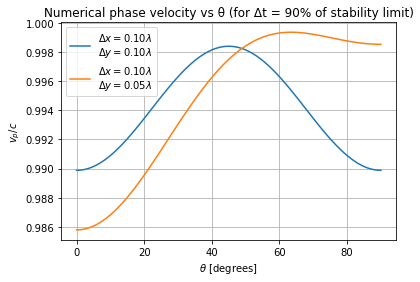

In [1]:
# Import script required packages
import numpy as np
import matplotlib.pyplot as plt
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def percent_stability_criterion(dx, dy, percent):
    # Computes a percent of the stability limit for the explicit 2D Formulation
    # Input: dx, dy, percent
    # Output: dt
    if dx == dy:
        dt = percent * dx / np.sqrt(2)
    else:
        dt = percent * 1 / (np.sqrt((1 / pow(dx, 2)) + (1 / pow(dy, 2))))
    return dt


def k_hat_newton(theta, dx, dy, dt, lambd):
    # Computes k_hat using the Newton-Raphson method
    # Input: theta [deg], dx, dy, dt, l
    # Output: k_hat
    theta = np.deg2rad(theta)
    # Define f and f dot
    f = lambda khat: ((1 / pow(dx, 2)) * pow(np.sin(khat * np.cos(theta) * dx / 2), 2)) + (
                (1 / pow(dy, 2)) * pow(np.sin(khat * np.sin(theta) * dy / 2), 2)) - (
                                 (1 / pow(dt, 2)) * pow(np.sin(np.pi * dt / lambd), 2))
    fdot = lambda khat: (np.cos(theta) / (2 * dx)) * np.sin(khat * np.cos(theta) * dx) + (
                np.sin(theta) / (2 * dy)) * np.sin(khat * np.sin(theta) * dy)
    # Stopping criteria
    n = 10  # Number of significant digits to be computed
    max_repetitions = 1000
    es = 0.5 * pow(10, (2 - n))  # Scarborough Criterion
    ea = 100
    k_prev = 2 * np.pi / lambd
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        k_next = k_prev - (f(k_prev) / fdot(k_prev))
        ea = np.fabs((k_next - k_prev) * 100 / k_next)
        k_prev = k_next
        if repetitions > max_repetitions:
            print('Max repetitions reached without achieving desired accuracy for E!')
            break
    k_hat = k_next
    return k_hat


def phase_velocity_vs_theta_diagram(dx, dy, dt, lambd, min_theta, max_theta):
    # Creates a numerical phase velocity diagram vs theta for theta interval [min_theta, max_theta]
    # Input: dx, dy, dt, lambd, min_theta, max_theta
    # Output: None (can plot figure using plt.show())
    step_size = 1
    total_size = int(((max_theta - min_theta) / step_size) + 1)
    vpc_values = np.zeros(total_size)
    # Compute k and v_p/c values
    for i in range(0, total_size):
        theta = i * step_size
        k = k_hat_newton(theta, dx, dy, dt, lambd)
        vpc_values[i] = 2 * np.pi / (lambd * k)
    # Plot output
    plt.plot(vpc_values, label="$\Delta x = %.2f \lambda$\n$\Delta y = %.2f \lambda$" % (dx, dy))
    plt.title("Numerical phase velocity vs θ (for Δt = 90% of stability limit)")
    plt.ylabel(r"$v_{p}/c$")
    plt.xlabel(r"$\theta$ [degrees]")
    plt.legend()
    return None


theta_start = 0
theta_end = 90

# Case A: Delta_x = Delta_y = lambda/10, Delta_t = 0.9 C.L.
lmbd = 1
Delta_x = lmbd / 10
Delta_y = lmbd / 10
Delta_t = percent_stability_criterion(Delta_x, Delta_y, 0.9)
phase_velocity_vs_theta_diagram(Delta_x, Delta_y, Delta_t, lmbd, theta_start, theta_end)

# Case B: Delta_x = lambda/10, Delta_y = lambda/20, Delta_t = 0.9 C.L.
lmbd = 1
Delta_x = lmbd / 10
Delta_y = lmbd / 20
Delta_t = percent_stability_criterion(Delta_x, Delta_y, 0.9)
phase_velocity_vs_theta_diagram(Delta_x, Delta_y, Delta_t, lmbd, theta_start, theta_end)

# Show resulting plot
plt.grid()
plt.show()